# 1. Define function for generating sequences of digits that our networks will attempt to learn

In [1]:
import random

In [2]:
def generate_seq(X):
    Y = []
    for i in range(len(X)):
        if i == 0:
            y = X[0]
        else:
            y = X[i] + X[0]
        if y >= 10:
            y = y - 10
        Y.append(y)
    return Y

In [3]:
Xtests = []
for i in range(5):
    Xtests.append(random.choices(range(10),k=random.choice(range(5,20))))
print("Printing pseudorandom x's:")
for Xtest in Xtests:
    print(Xtest)
print("\nPrinting y's:")
for Xtest in Xtests:
    print(generate_seq(Xtest))

Printing pseudorandom x's:
[7, 8, 8, 2, 7, 4, 1, 8, 5, 4, 2, 1, 8, 8]
[9, 1, 4, 7, 2, 0, 6, 5, 2, 7, 6, 7, 9, 3, 6, 6]
[1, 7, 4, 5, 3, 5]
[6, 2, 6, 7, 5]
[7, 4, 8, 3, 8, 9, 9, 6]

Printing y's:
[7, 5, 5, 9, 4, 1, 8, 5, 2, 1, 9, 8, 5, 5]
[9, 0, 3, 6, 1, 9, 5, 4, 1, 6, 5, 6, 8, 2, 5, 5]
[1, 8, 5, 6, 4, 6]
[6, 8, 2, 3, 1]
[7, 1, 5, 0, 5, 6, 6, 3]


# 2. Do machine learning

## 2.1 Make necessary imports

In [4]:
#import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

import time  # для оценки времени

import gc

from collections import defaultdict
import matplotlib.pyplot as plt

## 2.2 Prepare dataset with variable length sequences

In [5]:
Xs = []
for i in range(1001):
#     Xs.append(random.choices(range(10),k=random.choice(range(5,20))))
    Xs.append(random.choices(range(10),k=random.choice(range(5,20))))
Ys = []
for X in Xs:
#     Ys.append(generate_seq(X))
    Ys.append(generate_seq(X))

### The following won't work:

In [6]:
ds = TensorDataset(torch.as_tensor(Xs),torch.as_tensor(Ys)) #DOES NOT WORK IF LENTHS ARE DIFFERENT

ValueError: expected sequence of length 19 at dim 1 (got 15)

In [7]:
class MyDataSet(Dataset):
    def __init__(self,num,len_rng,fun):
        self.num = num
        self.Xs = []
        for i in range(self.num):
            self.Xs.append(random.choices(range(10),k=random.choice(range(len_rng[0],len_rng[1]))))
        self.Ys = []
        for X in self.Xs:
            self.Ys.append(fun(X))
    def __len__(self):
        return self.num
    def __getitem__(self,idx):
        X = torch.tensor(self.Xs[idx], dtype = torch.long)
        Y = torch.tensor(self.Ys[idx], dtype = torch.long)
        return X,Y

In [8]:
ds = MyDataSet(1000,(10,30),generate_seq)

In [9]:
ds[0]

(tensor([2, 2, 1, 6, 3, 1, 4, 7, 8, 6, 7, 8, 6, 6, 5, 4, 7, 5, 9, 1, 7, 4, 2]),
 tensor([2, 4, 3, 8, 5, 3, 6, 9, 0, 8, 9, 0, 8, 8, 7, 6, 9, 7, 1, 3, 9, 6, 4]))

In [10]:
train_data, test_data = torch.utils.data.random_split(ds, (len(ds)-int(len(ds)*0.3), int(len(ds)*0.3)))

In [11]:
def pad_and_pack(batch):
    input_tensors = []
    output_tensors = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        output_tensors.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    #4: create the padded version of the input and output
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    y_padded = torch.nn.utils.rnn.pad_sequence(output_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    y_packed = torch.nn.utils.rnn.pack_padded_sequence(y_padded, lengths, batch_first=False, enforce_sorted=False)
    return x_packed, y_packed
#     return x_packed, output_tensors

In [12]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False, collate_fn=pad_and_pack)

## 2.2 Define NN class, suitable for variablw length sequences

In [13]:
class EmbeddingPackable(nn.Module):
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer

    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input,
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(),
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)

### In out NN class we use the fact that in a packed sequence batches are concatenated, so we don't have to 
### flatten() in the batch dimension when calculating loss: our NN delivers "flattened" output already

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, rnnClass, input_size, embedding_size, hidden_size, num_classes):
        super().__init__()

        self.hidden_size = hidden_size
        self.embedding = EmbeddingPackable(nn.Embedding(input_size, embedding_size))
        self.hidden = rnnClass(embedding_size, hidden_size, batch_first=True)
        self.linoutput = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        out = self.embedding(X)
        hids_all, hid_last = self.hidden(out)
        if type(X) == torch.nn.utils.rnn.PackedSequence:
            predictions = self.linoutput(hids_all.data)          
        else:
            predictions = self.linoutput(hids_all.view(-1,self.hidden_size))
        return predictions

In [17]:
input_size, embedding_size, hidden_size, num_classes = 10, 64, 128, 10

In [18]:
criterion = torch.nn.CrossEntropyLoss()  # типичный лосс многоклассовой классификации

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 4.6 Define train function and a couple of additional functions

In [20]:
def weight_reset(m):
    if "reset_parameters" in dir(m):
        m.reset_parameters()
    return

In [21]:
def train(model, lossfu, optimizer, train_loader, test_loader, num_eps=10, device=device, tag=''):
    history = defaultdict(lambda: defaultdict(list))
    model.to(device)
    model.apply(weight_reset)
    start_all = time.time()
    for ep in range(num_eps):
        start_ep = time.time()
        iter_passed = 0
        train_loss, test_loss, train_acc, test_acc = 0.,0.,0.,0.
        model.train()
        for inputs, targets in train_loader:
            inputs  =  inputs.to(device)
            targets = targets.data.to(device)
            optimizer.zero_grad()
            answers = model(inputs)
            loss = criterion(answers, targets)
            train_loss += loss.item()
            train_acc += (answers.argmax(dim=1) == targets).sum().item()/answers.shape[0]
            loss.backward()
            optimizer.step()
            iter_passed += 1
        
            torch.cuda.empty_cache()
            gc.collect()
    
        train_acc /= iter_passed
        train_loss /= iter_passed
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        iter_passed = 0
        
        model.eval()
        for inputs, targets in test_loader:
            inputs  =  inputs.to(device)
            targets = targets.data.to(device)
#             optimizer.zero_grad()
            answers = model(inputs)
            loss = criterion(answers, targets)
            test_loss += loss.item()
            test_acc += (answers.argmax(dim=1) == targets).sum().item()/answers.shape[0]

            iter_passed += 1
        
            torch.cuda.empty_cache()
            gc.collect()
    
        test_acc /= iter_passed
        test_loss /= iter_passed
        history['loss']['val'].append(test_loss)
        history['acc']['val'].append(test_acc)

        print("Epoch {}. Time: {:.3f}, train loss: {:.3f}, train accuracy: {:.3f}, "
          "test loss: {:.3f}, test accuracy: {:.3f},".format(ep+1, time.time() - start_ep, 
                                                               train_loss, train_acc, test_loss, test_acc))
    print("Time total: {:.3f}".format(time.time() - start_all))
    return {'dict': history, 'tag': tag}

In [22]:
def plot_learning_curves(*args):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    if len(args)==1:
        plt.plot(args[0]['dict']['loss']['train'], label='train')
        plt.plot(args[0]['dict']['loss']['val'], label='val')
    elif len(args) > 1:
        #plt.suptitle("Сравнение ")
        for hist in args:
            plt.plot(hist['dict']['loss']['val'], label=hist['tag'])
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    if len(args)==1:
        plt.plot(args[0]['dict']['acc']['train'], label='train')
        plt.plot(args[0]['dict']['acc']['val'], label='val')
    elif len(args) > 1:
        for hist in args:
            plt.plot(hist['dict']['acc']['val'], label=hist['tag'])
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

## 4.7 Train model

In [24]:
model = NeuralNetwork(nn.RNN, 10, 64, 128, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [25]:
rnn_info = train(model,criterion,optimizer,train_loader,test_loader,tag="RNN",num_eps=20)

Epoch 1. Time: 10.764, train loss: 2.318, train accuracy: 0.120, test loss: 2.305, test accuracy: 0.145,
Epoch 2. Time: 10.729, train loss: 2.297, train accuracy: 0.139, test loss: 2.303, test accuracy: 0.152,
Epoch 3. Time: 10.714, train loss: 2.292, train accuracy: 0.147, test loss: 2.299, test accuracy: 0.152,
Epoch 4. Time: 10.989, train loss: 2.281, train accuracy: 0.157, test loss: 2.270, test accuracy: 0.182,
Epoch 5. Time: 10.549, train loss: 2.252, train accuracy: 0.191, test loss: 2.244, test accuracy: 0.190,
Epoch 6. Time: 10.813, train loss: 2.195, train accuracy: 0.211, test loss: 2.182, test accuracy: 0.200,
Epoch 7. Time: 10.542, train loss: 2.148, train accuracy: 0.215, test loss: 2.080, test accuracy: 0.247,
Epoch 8. Time: 10.953, train loss: 2.060, train accuracy: 0.230, test loss: 2.010, test accuracy: 0.244,
Epoch 9. Time: 10.562, train loss: 1.955, train accuracy: 0.236, test loss: 1.914, test accuracy: 0.246,
Epoch 10. Time: 10.486, train loss: 1.867, train accura

In [27]:
print(ds[0][0])
print(ds[0][1])
with torch.no_grad():
    model.cpu()
    print(model(ds[:1][0]).argmax(1).squeeze())
    print(f"Accuracy is {(model(ds[:1][0]).argmax(1) == ds[0][1]).sum()/len(ds[0][1])*100}%")

tensor([2, 2, 1, 6, 3, 1, 4, 7, 8, 6, 7, 8, 6, 6, 5, 4, 7, 5, 9, 1, 7, 4, 2])
tensor([2, 4, 3, 8, 5, 3, 6, 9, 0, 8, 9, 0, 8, 8, 7, 6, 9, 7, 1, 3, 9, 6, 4])
tensor([2, 9, 8, 8, 8, 8, 8, 2, 3, 1, 8, 3, 1, 8, 9, 9, 2, 9, 4, 6, 2, 8, 6])
Accuracy is 13.043478012084961%


In [28]:
model = NeuralNetwork(nn.GRU, 10, 64, 128, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [29]:
gru_info = train(model,criterion,optimizer,train_loader,test_loader,tag="GRU",num_eps=20)

Epoch 1. Time: 21.577, train loss: 2.308, train accuracy: 0.122, test loss: 2.296, test accuracy: 0.160,
Epoch 2. Time: 21.129, train loss: 2.296, train accuracy: 0.142, test loss: 2.291, test accuracy: 0.164,
Epoch 3. Time: 21.326, train loss: 2.281, train accuracy: 0.154, test loss: 2.281, test accuracy: 0.169,
Epoch 4. Time: 21.334, train loss: 2.255, train accuracy: 0.178, test loss: 2.226, test accuracy: 0.196,
Epoch 5. Time: 20.781, train loss: 2.109, train accuracy: 0.262, test loss: 1.978, test accuracy: 0.351,
Epoch 6. Time: 21.252, train loss: 1.653, train accuracy: 0.538, test loss: 1.309, test accuracy: 0.706,
Epoch 7. Time: 19.640, train loss: 0.893, train accuracy: 0.874, test loss: 0.572, test accuracy: 0.953,
Epoch 8. Time: 20.850, train loss: 0.355, train accuracy: 0.992, test loss: 0.234, test accuracy: 0.999,
Epoch 9. Time: 20.820, train loss: 0.154, train accuracy: 1.000, test loss: 0.116, test accuracy: 1.000,
Epoch 10. Time: 20.857, train loss: 0.085, train accura

In [30]:
print(ds[0][0])
print(ds[0][1])
with torch.no_grad():
    model.cpu()
    print(model(ds[:1][0]).argmax(1).squeeze())
    print(f"Accuracy is {(model(ds[:1][0]).argmax(1) == ds[0][1]).sum()/len(ds[0][1])*100}%")

tensor([2, 2, 1, 6, 3, 1, 4, 7, 8, 6, 7, 8, 6, 6, 5, 4, 7, 5, 9, 1, 7, 4, 2])
tensor([2, 4, 3, 8, 5, 3, 6, 9, 0, 8, 9, 0, 8, 8, 7, 6, 9, 7, 1, 3, 9, 6, 4])
tensor([2, 4, 3, 8, 5, 3, 6, 9, 0, 8, 9, 0, 8, 8, 7, 6, 9, 7, 1, 3, 9, 6, 4])
Accuracy is 100.0%


In [31]:
model = NeuralNetwork(nn.LSTM, 10, 64, 128, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [35]:
lstm_info = train(model,criterion,optimizer,train_loader,test_loader,tag="LSTM",num_eps=20)

Epoch 1. Time: 10.449, train loss: 2.305, train accuracy: 0.107, test loss: 2.301, test accuracy: 0.128,
Epoch 2. Time: 10.441, train loss: 2.296, train accuracy: 0.129, test loss: 2.298, test accuracy: 0.151,
Epoch 3. Time: 10.478, train loss: 2.292, train accuracy: 0.138, test loss: 2.296, test accuracy: 0.156,
Epoch 4. Time: 10.464, train loss: 2.289, train accuracy: 0.141, test loss: 2.293, test accuracy: 0.160,
Epoch 5. Time: 10.457, train loss: 2.284, train accuracy: 0.149, test loss: 2.290, test accuracy: 0.161,
Epoch 6. Time: 10.445, train loss: 2.270, train accuracy: 0.163, test loss: 2.272, test accuracy: 0.178,
Epoch 7. Time: 10.437, train loss: 2.216, train accuracy: 0.207, test loss: 2.133, test accuracy: 0.259,
Epoch 8. Time: 10.398, train loss: 1.949, train accuracy: 0.337, test loss: 1.685, test accuracy: 0.451,
Epoch 9. Time: 10.360, train loss: 1.383, train accuracy: 0.492, test loss: 1.231, test accuracy: 0.497,
Epoch 10. Time: 10.542, train loss: 1.023, train accura

In [36]:
print(ds[0][0])
print(ds[0][1])
with torch.no_grad():
    model.cpu()
    print(model(ds[:1][0]).argmax(1).squeeze())
    print(f"Accuracy is {(model(ds[:1][0]).argmax(1) == ds[0][1]).sum()/len(ds[0][1])*100}%")

tensor([2, 2, 1, 6, 3, 1, 4, 7, 8, 6, 7, 8, 6, 6, 5, 4, 7, 5, 9, 1, 7, 4, 2])
tensor([2, 4, 3, 8, 5, 3, 6, 9, 0, 8, 9, 0, 8, 8, 7, 6, 9, 7, 1, 3, 9, 6, 4])
tensor([2, 4, 3, 8, 5, 3, 6, 9, 0, 8, 9, 0, 8, 8, 7, 6, 9, 7, 1, 3, 9, 6, 4])
Accuracy is 100.0%


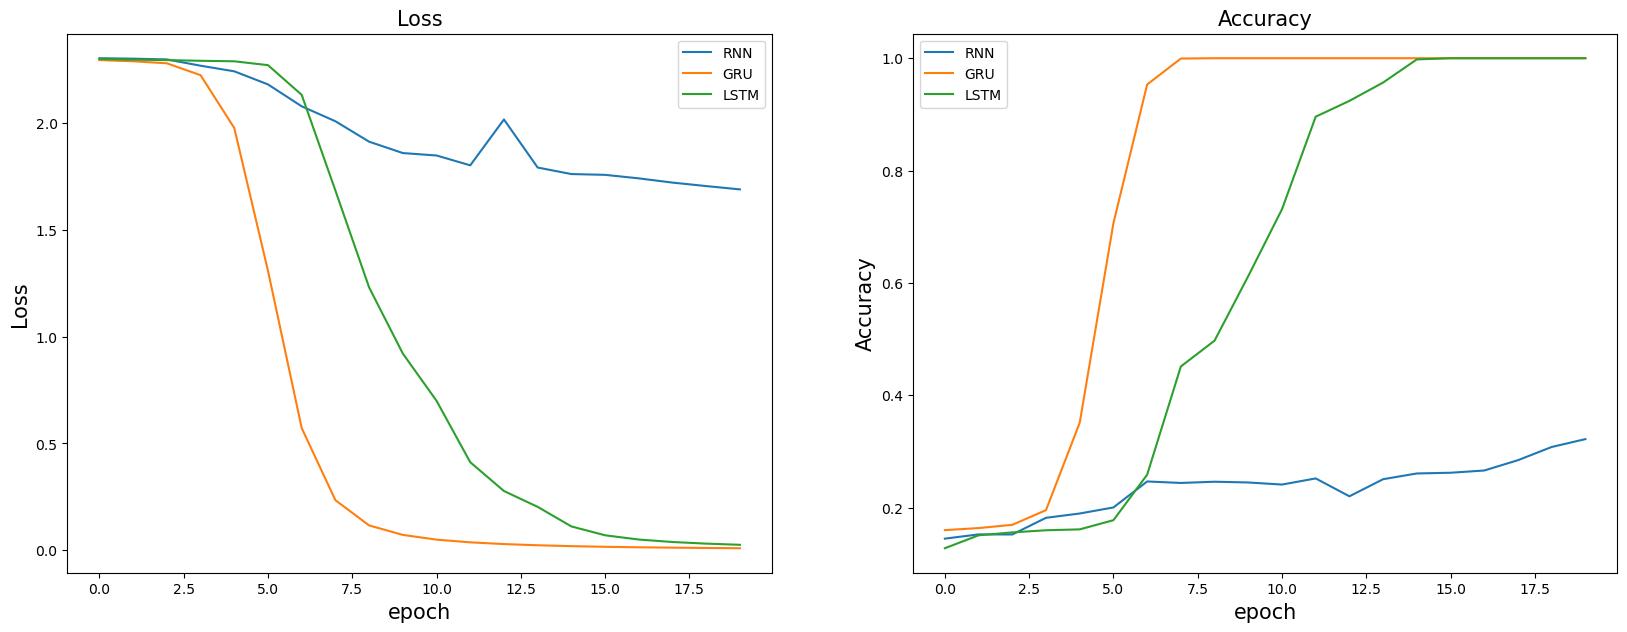

In [37]:
plot_learning_curves(rnn_info, gru_info, lstm_info)